# Basic Neural Network model built with Pytorch
### (Not using transfer learning)

In [0]:
import torch

# MNIST Fashion is built into Pytorch
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F

from torch import optim, utils

# to show the images
import helper # this doesn't work with Google Colab

import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.ToTensor(), 
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
train_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=train_transforms)
test_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=test_transforms)


Processing...
Done!


In [0]:
# loading the image datasets and transforms with dataloaders
# batch size for GPU on colab can be around 32 depending on size
# but for this one we can go all the way up to 64
batch_size = 64

# sampler is being used because that is how we split the training and validation data
  # shuffle == True due to under/overfitting
  # (by default it's set true when using sampler)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True)

## Finding out the image info
 showing what type the images are and the subsequent shapes 
 ### this is important because of tensor multiplication

this shows that it's 64 x 1 x 28 x 28
  meaning, it's got 64 images, 1 color chanel (gray scale), 
  and the image size is 28x28

In [0]:
# initializing an iterator to iterate over the training data
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


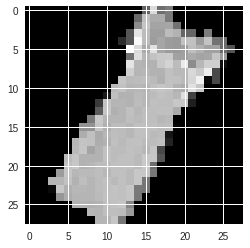

In [0]:
plt.imshow(images[0].numpy().squeeze(), cmap="Greys_r");

## Very basic feed forward Neural network using gradient descent

In [0]:
# building the classifier

class Neural_Network(nn.Module):
    
    def __init__(self):
      
  # inhereting __init__ from Pytorch's nn.Module
      super().__init__()

# first connected layer, starting out pretty big and getting smaller as
# the model progresses (this is not a rule, some layers can be equal,
# BUT the final layer HAS to fit your classification output number
      self.full_connected_layer1 = nn.Linear(784, 256)
      self.full_connected_layer2 = nn.Linear(256, 128)
      self.full_connected_layer3 = nn.Linear(128, 64)

# final layer, only has 10 outputs since that's how many 
# classifications we have in our dataset 
# ( there are only ten types of clothing options)
      self.full_connected_layer4 = nn.Linear(64, 10)

# Adding dropout to prevent overfitting (this "drops out" a certain percentage 
# of items you're training on to prevent the Model from memorizing some pattern
# that we can't see (like the actual pattern of the images in the 
# folders AKA how they're loaded))
      self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
      
# make sure input tensor is flattened (easiest way to this is this syntax -1)
      x = x.view(x.shape[0], -1)
# applying dropout to each hidden layer to prevent overfitting
# using Rectified Linear Unit for the activation
# and Softmax for the output layer
      x = self.dropout(F.relu(self.full_connected_layer1(x)))
      x = self.dropout(F.relu(self.full_connected_layer2(x)))
      x = self.dropout(F.relu(self.full_connected_layer3(x)))
      
      x = F.log_softmax(self.ouput(x), dim=1)

      return x

In [0]:
# intializing the model from the class we just built
model = Neural_Network()

# using the NLLLoss as the criterion and Standard Gradient Descent as the optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
epochs = 10
steps = 0

train_losses, test_losses = [], []
for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print(f'Epoch: {epoch+1}/{epochs}',
              f'Training Loss: {train_losses[-1]:.4f}',
              f'Test Loss: {test_losses[-1]:.4f}',
              f'Test Accuracy: {(accuracy/len(test_loader)):.4f}')

Epoch: 1/10 Training Loss: 0.3235 Test Loss: 0.3870 Test Accuracy: 0.8658
Epoch: 2/10 Training Loss: 0.3182 Test Loss: 0.3901 Test Accuracy: 0.8566
Epoch: 3/10 Training Loss: 0.3176 Test Loss: 0.3958 Test Accuracy: 0.8588
Epoch: 4/10 Training Loss: 0.3124 Test Loss: 0.3786 Test Accuracy: 0.8681
Epoch: 5/10 Training Loss: 0.3119 Test Loss: 0.3640 Test Accuracy: 0.8730
Epoch: 6/10 Training Loss: 0.3083 Test Loss: 0.3699 Test Accuracy: 0.8667
Epoch: 7/10 Training Loss: 0.3052 Test Loss: 0.3792 Test Accuracy: 0.8686
Epoch: 8/10 Training Loss: 0.3044 Test Loss: 0.3858 Test Accuracy: 0.8681
Epoch: 9/10 Training Loss: 0.3014 Test Loss: 0.3710 Test Accuracy: 0.8688
Epoch: 10/10 Training Loss: 0.2992 Test Loss: 0.3935 Test Accuracy: 0.8660


## Notice how this is cool and all, but we really need to use this in the real world

 - That's where having a validation set (a test before the testing set) is extremely helpful
 - AND we need to save our model

Here's a little preview of the saving. Check the CNN Basic model for some validation data

In [0]:
print("The model: \n", model, '\n')

print("The state dict keys after training for 10 epochs: \n\n", model.state_dict().keys())

The model: 
 Neural_Network(
  (full_connected_layer1): Linear(in_features=784, out_features=256, bias=True)
  (full_connected_layer2): Linear(in_features=256, out_features=128, bias=True)
  (full_connected_layer3): Linear(in_features=128, out_features=64, bias=True)
  (ouput): Linear(in_features=64, out_features=10, bias=True)
) 

The state dict keys after training for 10 epochs: 

 odict_keys(['full_connected_layer1.weight', 'full_connected_layer1.bias', 'full_connected_layer2.weight', 'full_connected_layer2.bias', 'full_connected_layer3.weight', 'full_connected_layer3.bias', 'ouput.weight', 'ouput.bias'])


In [0]:
torch.save(model.state_dict(), 'toy_model.pth')

In [0]:
# loading that model's .pth
state_dict = torch.load('toy_model.pth')
print(state_dict.keys())

odict_keys(['full_connected_layer1.weight', 'full_connected_layer1.bias', 'full_connected_layer2.weight', 'full_connected_layer2.bias', 'full_connected_layer3.weight', 'full_connected_layer3.bias', 'ouput.weight', 'ouput.bias'])


In [0]:
# loading the state dicitonary to a model
model.load_state_dict(state_dict)